In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [4]:
data = pd.read_csv("../input/data4a.csv")
data["f_num"] = data.f.replace("C", 0).replace("T", 1)

In [19]:
data.head()

,N,y,x,f,f_num
0,8,1,9.76,C,0
1,8,6,10.48,C,0
2,8,5,10.83,C,0
3,8,6,10.94,C,0
4,8,1,9.37,C,0


/Users/makora/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/makora/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/makora/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/makora/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/makora/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/makora/.pyenv

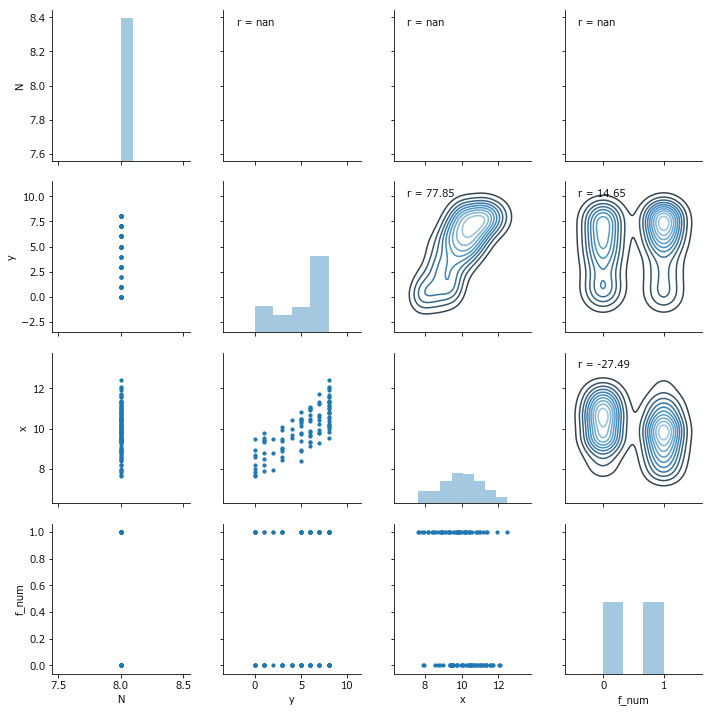

In [14]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r*100),
                xy=(.1, .9), xycoords=ax.transAxes)
g = sns.PairGrid(data[["N", "y", "x", "f_num"]], palette=["red"])
g.map_lower(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_upper(corrfunc)

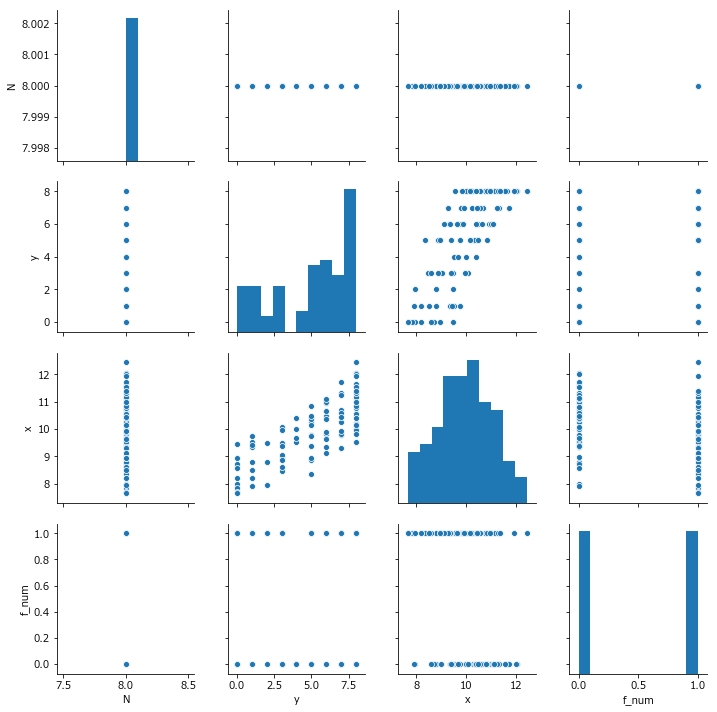

In [18]:
sns.pairplot(data)

## 問題設定
xとfで，Nのうち，生存していたyを推測する

## モデル式
$$q_i = b_1 + b_2x + b_3f$$
$$y_i \sim Binomial(N_i, q_i)$$

In [20]:
def model(x, f, n, y):
    b1 = pyro.sample("b1", dist.Normal(0, 10.))
    b2 = pyro.sample("b2", dist.Normal(0, 10.))
    b3 = pyro.sample("b3", dist.Normal(0, 10.))
    
    logits = b1 + b2 * x + b3 * f
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Binomial(n, logits=logits), obs=y)

In [21]:
x = torch.tensor(data.x)
f = torch.tensor(data.f_num).float()
n = torch.tensor(data.N).float()
y = torch.tensor(data.y).float()

In [34]:
hmc_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc_posterior = MCMC(hmc_kernel, num_samples=1000, num_chains=4, warmup_steps=2000).run(x, f, n, y)

In [35]:
sites = ["b1", "b2", "b3"]
mcmc_marginal = EmpiricalMarginal(mcmc_posterior, sites)._get_samples_and_weights()[0]

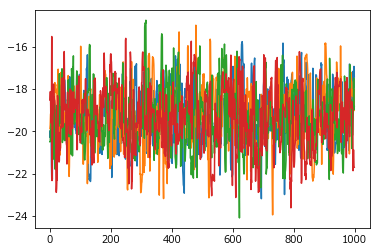

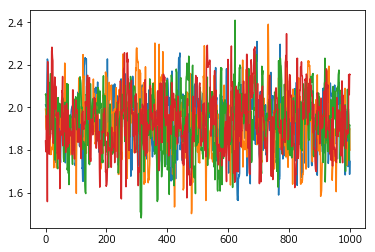

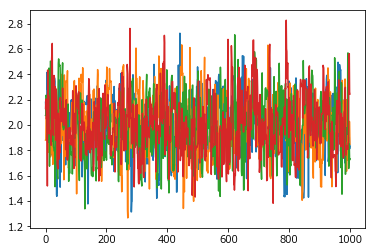

In [36]:
for j in range(3):
    plt.figure()
    for i in range(4):
        plt.plot(range(1000), mcmc_marginal[i, :, j].numpy())

In [37]:
df_samples = pd.DataFrame(mcmc_marginal.reshape(-1, len(sites)).numpy(), columns=sites)

In [38]:
result = df_samples.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
result["mean"] = df_samples.mean(0)
result

,0.025,0.25,0.5,0.75,0.975,mean
b1,-22.115252,-20.192069,-19.289414,-18.315599,-16.543443,-19.287731
b2,1.660123,1.834080,1.928961,2.016274,2.202526,1.928478
b3,1.559702,1.842129,1.983386,2.148760,2.445606,1.994105


In [43]:
def predict_model(x, f, n):
    b1 = pyro.sample("b1", dist.Normal(0, 10.))
    b2 = pyro.sample("b2", dist.Normal(0, 10.))
    b3 = pyro.sample("b3", dist.Normal(0, 10.))
    
    logits = b1 + b2 * x + b3 * f
    pyro.sample("y", dist.Binomial(n, logits=logits))
mcmc_predictive = TracePredictive(predict_model, mcmc_posterior, num_samples=1000).run(x, f, n)
y_samples = EmpiricalMarginal(mcmc_predictive, "y")._get_samples_and_weights()[0]

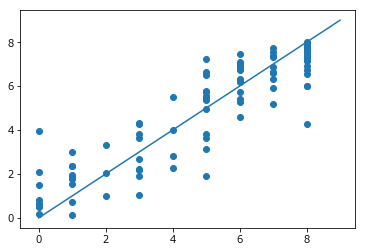

In [47]:
plt.plot(range(0, 10), range(0, 10))
plt.scatter(data.y, y_samples.mean(0).numpy())